### Import stuff

In [24]:
import numpy as np
import gvar as gv
import sys
import pandas as pd
import os
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['figure.figsize']  = (6.75, 6.75/1.618034333)
mpl.rcParams['font.size']  = 20
mpl.rcParams['legend.fontsize'] =  16
mpl.rcParams["lines.markersize"] = 5
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

sys.path.append('../')
import fitter.model_average as md

def save_fig(fig, filename):

    project_path = os.path.normpath(os.path.join(os.getcwd(), os.pardir))
    if not os.path.exists(os.path.normpath(project_path+'/tmp/')):
        os.makedirs(os.path.normpath(project_path+'/tmp/'))

    filepath = project_path+'/tmp/'+filename+'.pdf'
    fig.savefig(filepath, transparent=True, bbox_inches='tight')
    #print('Saving to', filepath)
    return fig

from importlib import reload
reload(md)

<module 'fitter.model_average' from '../fitter/model_average.py'>

### Specify fits to compare in model breakdown plot

In [25]:
collections = {
    'quoted' : '2020_12_09-improved_variable_w0orig',
    
    #'emp-1' : '2020_11_22-empirical_order',
    #'emp-2' : '2020_11_22-empirical_disc',

    #'excld-ms' : '2020_12_09-improved_variable_w0orig_excl_a12m220ms',
    #'excld-a06' : '2020_12_09-improved_variable_w0orig_excl_a06m310L'
}
mdl_avg_dict = {clctn : md.model_average(collections[clctn]) for clctn in collections}

for clctn in mdl_avg_dict:
    print(clctn, mdl_avg_dict[clctn].average('w0'))
    print(clctn, mdl_avg_dict[clctn].average('sqrt_t0'))

quoted 0.1709(12)
quoted 0.1422(11)
excld-ms 0.1716(11)
excld-ms 0.1430(11)
excld-a06 0.1693(14)
excld-a06 0.1412(13)


### Make model breakdown plot

In [26]:
other_collabs = {
    '2' : {
        'ALPHA [2013]' : { 
            'w0'      : gv.gvar('0.1757(13)'),  # https://arxiv.org/abs/1311.5585
            'sqrt_t0' : gv.gvar('0.1535(12)'),
        },
    },
    '2+1' : {
        'BMWc [2012]' : {
            'w0'      : gv.gvar('0.1755(18)'), # https://arxiv.org/abs/1203.4469
            'sqrt_t0' : gv.gvar('0.1465(25)'),
        },
        'HotQCD [2014]' : {
            'w0'      : gv.gvar('0.1749(14)'), # https://arxiv.org/abs/1407.6387
            #'sqrt_t0' : not in paper
        },
        'RBC [2014]' : {
            'w0'      : gv.gvar('0.17250(91)'), # https://arxiv.org/abs/1411.7017
            'sqrt_t0' : gv.gvar('0.14389(81)'),
        },
        'QCDSF-UKQCD [2015]' : {
            'w0'      : gv.gvar('0.1808(25)'), # https://arxiv.org/abs/1508.05916
            'sqrt_t0' : gv.gvar('0.1511(24)'),
        },
        'CLS [2017]' : {
            'sqrt_t0' : gv.gvar('0.1467(16)'),
        }
    },
    '2+1+1' : {
        'HPQCD [2013]' : {
            'w0'      : gv.gvar('0.1715(9)'),
            'sqrt_t0' : gv.gvar('0.1420(8)'),
        },
        'MILC [2015]' : {
            'w0'      : gv.gvar('0.1714(15)'),
            'sqrt_t0' : gv.gvar('0.1416(8)'),
        },
    },
    '1+1+1+1' : {
        'BMWc$^*$ [2020]' : {
            'w0'      : gv.gvar('0.17236(70)'), # 0.17180(39) # https://arxiv.org/abs/2002.12347
            #'sqrt_t0' : not in paper
        },
    },
}


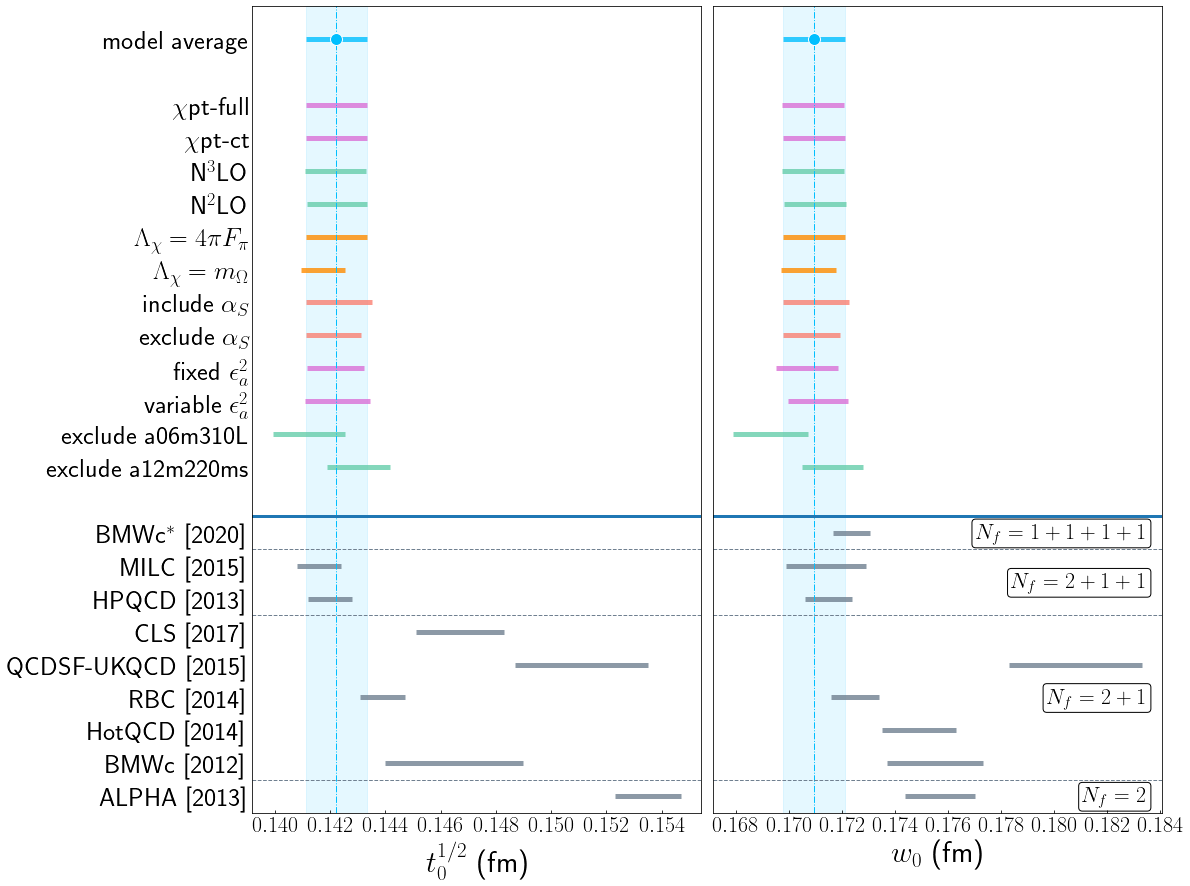

In [27]:
def plot_model_breakdown(mdl_avg_dict):
    main_result_color = 'deepskyblue'
    colors = ['salmon', 'darkorange', 'mediumaquamarine', 'orchid',] 
    # For convenience
    def blank_line(label=None, **kwargs):
        nonlocal y
        nonlocal labels
        nonlocal y_color

        if label is None:
            pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
            plt.axhline(y-0.5, ls='--', color='slategrey', **kwargs)  
        elif label == '':
            y_color += 1
            y_color %= len(colors)
        else:
            y += 1
            y_color += 1
            y_color %= len(colors)
            labels.append(label)


    
    def plot_text(x, y, label):
        plt.text(x, y, label, fontsize=22, horizontalalignment='right', bbox={'facecolor':'None','boxstyle':'round,pad=0.17'})


    def amend_plot(value, label, color, starred=False):
        nonlocal y
        nonlocal labels

        x = gv.mean(value)
        xerr = gv.sdev(value)
        plt.errorbar(x=x, y=y, xerr=xerr, yerr=0.0,
                    alpha=0.8, color=color, elinewidth=5.0)
        if starred:
            plt.plot(x, y, color=main_result_color, marker='o',  mec='white', ms=12, zorder=3)
        labels.append(str(label))
        y += 1 

    # Make fig
    fig = plt.figure(figsize=(16, 14))
    for j, param in enumerate(['sqrt_t0', 'w0']):

        if j == 0:
            axes = plt.axes([0.10,0.10,0.39,0.8])
        elif j == 1:
            axes = plt.axes([0.50,0.10,0.39,0.8])


        if param == 'w0':
            observable = 'w0'
            xlabel = r'$w_0$ (fm)'
        elif param == 'sqrt_t0':
            observable = 't0'
            xlabel = r'$t_0^{1/2}$ (fm)'
        else:
            return None


        y = 0
        y_color = -3
        labels = []


            
        # Initialize
        
        #plt.axes([0.145,0.145,0.85,0.85])

        # Show band
        avg = mdl_avg_dict['quoted'].average(param)
        pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
        plt.axvspan(pm(avg, -1), pm(avg, +1), alpha=0.1, color=main_result_color)
        plt.axvline(pm(avg, 0), ls='-.', color=main_result_color)


        # First show other collaborations
        for Nf in other_collabs:
            dy = y
            for collab in (other_collabs[Nf]):
                if param in other_collabs[Nf][collab]:
                    param_value = other_collabs[Nf][collab][param]
                    amend_plot(param_value, collab, 'slategrey')
                else:
                    blank_line(collab)

            blank_line()
            if observable == 't0':
                pass
                #plot_text(0.1480, y - 0.75 -(y - dy)/2, r'$N_f = %s$'%Nf)
            elif observable == 'w0':
                plot_text(0.1835, y - 0.65 -(y - dy)/2, r'$N_f = %s$'%Nf)


        y_color = -3
        plt.axhline(y-0.5, lw=3)
        

        # ------
        # Separate
        blank_line(' ')

        #amend_plot(mdl_avg_dict['excld-ms'].average(param), 'exclude a12m220ms', colors[y_color])
        #amend_plot(mdl_avg_dict['excld-a06'].average(param), 'exclude a06m310L', colors[y_color])


        # ------
        # Separate
        blank_line('')

        # exclude alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['eps2a_defn'] == 'variable']
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'variable $\epsilon^2_a$', colors[y_color])

        # include alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['eps2a_defn'] == 'w0_original']
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'fixed $\epsilon^2_a$', colors[y_color])



        # ------
        # Separate
        blank_line('')

        # exclude alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_alphas'] == False]
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'exclude $\alpha_S$', colors[y_color])

        # include alpha_s
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_alphas'] == True]
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'include $\alpha_S$', colors[y_color])
        

        # ------
        # Separate
        #blank_line()


        # ------
        # Separate
        blank_line('')

        # chiral cutoff: mO 
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['chiral_cutoff'] == 'mO']
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'$\Lambda_\chi = m_\Omega$', colors[y_color])

        # chiral cutoff: Fpi
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['chiral_cutoff'] == 'Fpi']
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'$\Lambda_\chi = 4 \pi F_\pi$', colors[y_color])


        # ----
        # Separate
        blank_line('')

        # n2lo-full fits
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['order'] == 'n2lo']
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'N$^2$LO', colors[y_color])

        # n3lo-full fits
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['order'] == 'n3lo']
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'N$^3$LO', colors[y_color])


        # ----
        # Separate
        blank_line('')

        # ct only
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_log'] == False]
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'$\chi$pt-ct', colors[y_color])

        # xpt only
        models = [mdl for mdl in mdl_avg_dict['quoted'].get_model_names(observable=observable) 
            if mdl_avg_dict['quoted']._get_model_info_from_name(mdl)['include_log'] == True]
        amend_plot(mdl_avg_dict['quoted'].average(param, models=models), r'$\chi$pt-full', colors[y_color])

        # Separate
        blank_line(' ')
        amend_plot(mdl_avg_dict['quoted'].average(param), r'model average', main_result_color, True)






        # Format axes
        plt.xticks(fontsize=22)
        #plt.locator_params(axis='x', nbins=9)
        #for n, l in enumerate(axes.xaxis.get_ticklabels()):
        #    if n % 2 != 0:
        #        l.set_visible(False)
        
        if j == 0:
            plt.tick_params(axis='y', left=False, labelsize=26)
            plt.yticks(range(len(labels)), labels)
        else:
            plt.yticks([])
        plt.ylim(-0.5, y)

        plt.xlabel(xlabel, fontsize=30)

    plt.tight_layout()
    fig = plt.gcf()
    plt.close()

    return fig

plot_model_breakdown(mdl_avg_dict)
save_fig(plot_model_breakdown(mdl_avg_dict), 'model_breakdown', )
    

### Plot all fits

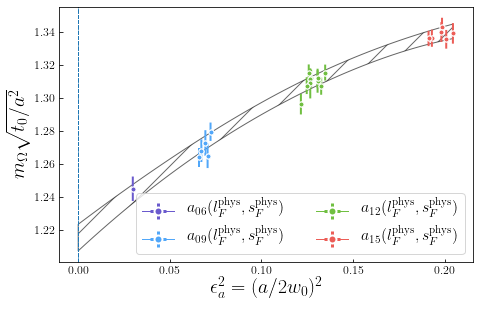

In [36]:
import fitter.data_loader as dl
import fitter.fit_manager as fm
import fitter.fitter as fit
reload(fm)

def save_fit_figs(model_average):
    #highest_weight_model = model_average.get_model_names(by_weight=True)[0]
    representative_model = 'Fpi_n3lo_log_log2_fv'

    data_loader = dl.data_loader(model_average.collection)
    gv_data = data_loader.gv_data
    model_info = data_loader.get_model_info_from_name(representative_model)
    prior = data_loader.get_prior(model=representative_model)
    phys_point_data = data_loader.phys_point_data
    
    fit_manager = fm.fit_manager(
        phys_point_data=phys_point_data, 
        fit_data=gv_data, 
        model_info=model_info,
        prior=prior)

    #fit_manager.plot_fit('a', observable='t0', show_legend=True)#, ylim=(1.35, 1.55))
    save_fig(fit_manager.plot_fit('a', observable='w0', show_legend=True), 'w0_fit_vs_a')
    save_fig(fit_manager.plot_fit('a', observable='t0', show_legend=True), 't0_fit_vs_a')
    save_fig(fit_manager.plot_fit('pi', observable='w0', show_legend=False), 'w0_fit_vs_l')
    save_fig(fit_manager.plot_fit('pi', observable='t0', show_legend=False), 't0_fit_vs_l')

save_fit_figs(mdl_avg_dict['quoted'])

In [55]:
def format_table(model_average):

    fit_results = model_average.fit_results

    output = '''\
    \\begin{ruledtabular} \\centering
    \\begin{tabular}{ l c c c c}
    Model & $w_0$ & $w_0 m_\Omega$ & \\texttt{logGBF} & $\chi_\\nu$ & $Q$ & weight \\\ \\midrule[0.5pt]
    '''

    calculate_weight = lambda model_k : np.exp(fit_results[model_k]['logGBF']) / np.sum([np.exp(fit_results[model_l]['logGBF']) for model_l in list(fit_results)])


    for j, model in enumerate(sorted(list(fit_results), key = lambda model : -fit_results[model]['logGBF'])):
        #if j%5 == 0:
        #    output += '\\midrule[0.5pt] \n'
            
        results = [fit_results[model][key] for key in ['name', 'w0', 'logGBF', 'chi2/df', 'Q']]

        results.insert(2, fit_results[model]['w0'] *model_average._get_phys_point_data()['mO'] / model_average._get_phys_point_data()['hbarc'])
        results.append(calculate_weight(model))

        output += '\\texttt{{{}}} & {} & {} &{:.2f} & {:.2f} & {:.2f} & {:.3f} \\\ \n'.format(*results).replace('_', '\_').replace('\_log2', '')

    output += '\\midrule[0.5pt] \n'
    output += 'Model Average & {} & & & &'.format('a')


    output += '''\
    \\end{tabular}
    \\end{ruledtabular}
    '''

    return output

print(format_table(mdl_avg_dict['quoted']))

    \begin{ruledtabular} \centering
    \begin{tabular}{ l c c c c}
    Model & $w_0$ & $w_0 m_\Omega$ & \texttt{logGBF} & $\chi_\nu$ & $Q$ & weight \\ \midrule[0.5pt]
    \texttt{Fpi\_n3lo\_log\_alphas} & 0.1710(13) & 1.449(11) &65.35 & 1.05 & 0.40 & 0.079 \\ 
\texttt{Fpi\_n3lo\_log} & 0.1706(11) & 1.4459(90) &65.35 & 1.06 & 0.39 & 0.079 \\ 
\texttt{Fpi\_n3lo\_log\_alphas\_fv} & 0.1710(13) & 1.449(11) &65.29 & 1.05 & 0.40 & 0.075 \\ 
\texttt{Fpi\_n3lo\_alphas} & 0.1711(13) & 1.450(11) &65.29 & 1.07 & 0.37 & 0.075 \\ 
\texttt{Fpi\_n3lo\_alphas\_fv} & 0.1711(13) & 1.450(11) &65.29 & 1.07 & 0.37 & 0.075 \\ 
\texttt{Fpi\_n3lo\_log\_fv} & 0.1706(11) & 1.4459(90) &65.29 & 1.06 & 0.38 & 0.075 \\ 
\texttt{Fpi\_n3lo} & 0.1706(10) & 1.4462(89) &65.28 & 1.08 & 0.36 & 0.074 \\ 
\texttt{Fpi\_n3lo\_fv} & 0.1706(10) & 1.4462(89) &65.28 & 1.08 & 0.36 & 0.074 \\ 
\texttt{Fpi\_n2lo\_log\_alphas} & 0.1711(13) & 1.450(11) &64.99 & 1.11 & 0.32 & 0.056 \\ 
\texttt{Fpi\_n2lo\_log} & 0.1707(11) & 1.4467(89) 